# Learn pseudotime analysis

- https://scanpy.readthedocs.io/en/stable/tutorials.html
- https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', FutureWarning)

In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=75, facecolor='white')
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


Download data set

```bash
%%bash

wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE72nnn/GSE72857/suppl/GSE72857_umitab.txt.gz
```

## Load data

In [4]:
def paul15(filename = 'data/paul15.h5'):
    import h5py
    import anndata as ad

    with h5py.File(filename, 'r') as f:
        # Coercing to float32 for backwards compatibility
        X = f['data.debatched'][()].astype(np.float32)
        gene_names = f['data.debatched_rownames'][()].astype(str)
        cell_names = f['data.debatched_colnames'][()].astype(str)
        clusters = f['cluster.id'][()].flatten().astype(int)
        infogenes_names = f['info.genes_strings'][()].astype(str)

    # each row has to correspond to a observation, therefore transpose
    adata = ad.AnnData(X.transpose(), dtype=X.dtype)
    adata.var_names = gene_names
    adata.row_names = cell_names
    # names reflecting the cell type identifications from the paper
    cell_type = 6 * ['Ery']
    cell_type += 'MEP Mk GMP GMP DC Baso Baso Mo Mo Neu Neu Eos Lymph'.split()
    adata.obs['paul15_clusters'] = [f'{i}{cell_type[i-1]}' for i in clusters]
    # make string annotations categorical (optional)
    adata._sanitize()
    # just keep the first of the two equivalent names per gene
    adata.var_names = [gn.split(';')[0] for gn in adata.var_names]
    # remove 10 corrupted gene names
    infogenes_names = np.intersect1d(infogenes_names, adata.var_names)
    # restrict data array to the 3461 informative genes
    adata = adata[:, infogenes_names].copy()
    # usually we'd set the root cell to an arbitrary cell in the MEP cluster
    # adata.uns['iroot'] = np.flatnonzero(adata.obs['paul15_clusters'] == '7MEP')[0]
    # here, set the root cell as in Haghverdi et al. (2016)
    # note that other than in Matlab/R, counting starts at 0
    adata.uns['iroot'] = 840

    return adata

In [5]:
if not os.path.exists('write'):
    os.makedirs('write')
results_file = 'write/paul15.h5ad'

In [6]:
adata = paul15()

## Prepocessing and visualization

Reproduces the preprocessing of [Zheng17]_ – the Cell Ranger R Kit of 10x
Genomics.

In [7]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [8]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


In [9]:
%%time
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:09)
CPU times: user 11.3 s, sys: 419 ms, total: 11.8 s
Wall time: 10.8 s


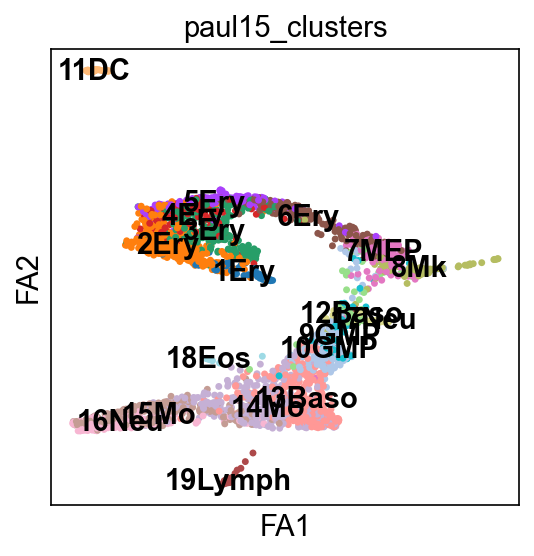

In [10]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

## Clustering and PAGA

In [11]:
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Annotate the clusters using marker genes

| cell type | marker |
| :-------- | :----- |
| HSCs | Procr |
| Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
| Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
| Monocytes | Irf8, Csf1r, Ctsg, Mpo |
| Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
| Basophils | Mcpt8, Prss34 |
| B cells | Cd19, Vpreb2, Cd79a |
| Mast cells | Cma1, Gzmb, CD117/C-Kit |
| Mast cells & Basophils | Ms4a2, Fcer1a, Cpa3, CD203c (human) |

In [12]:
sc.tl.paga(adata, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


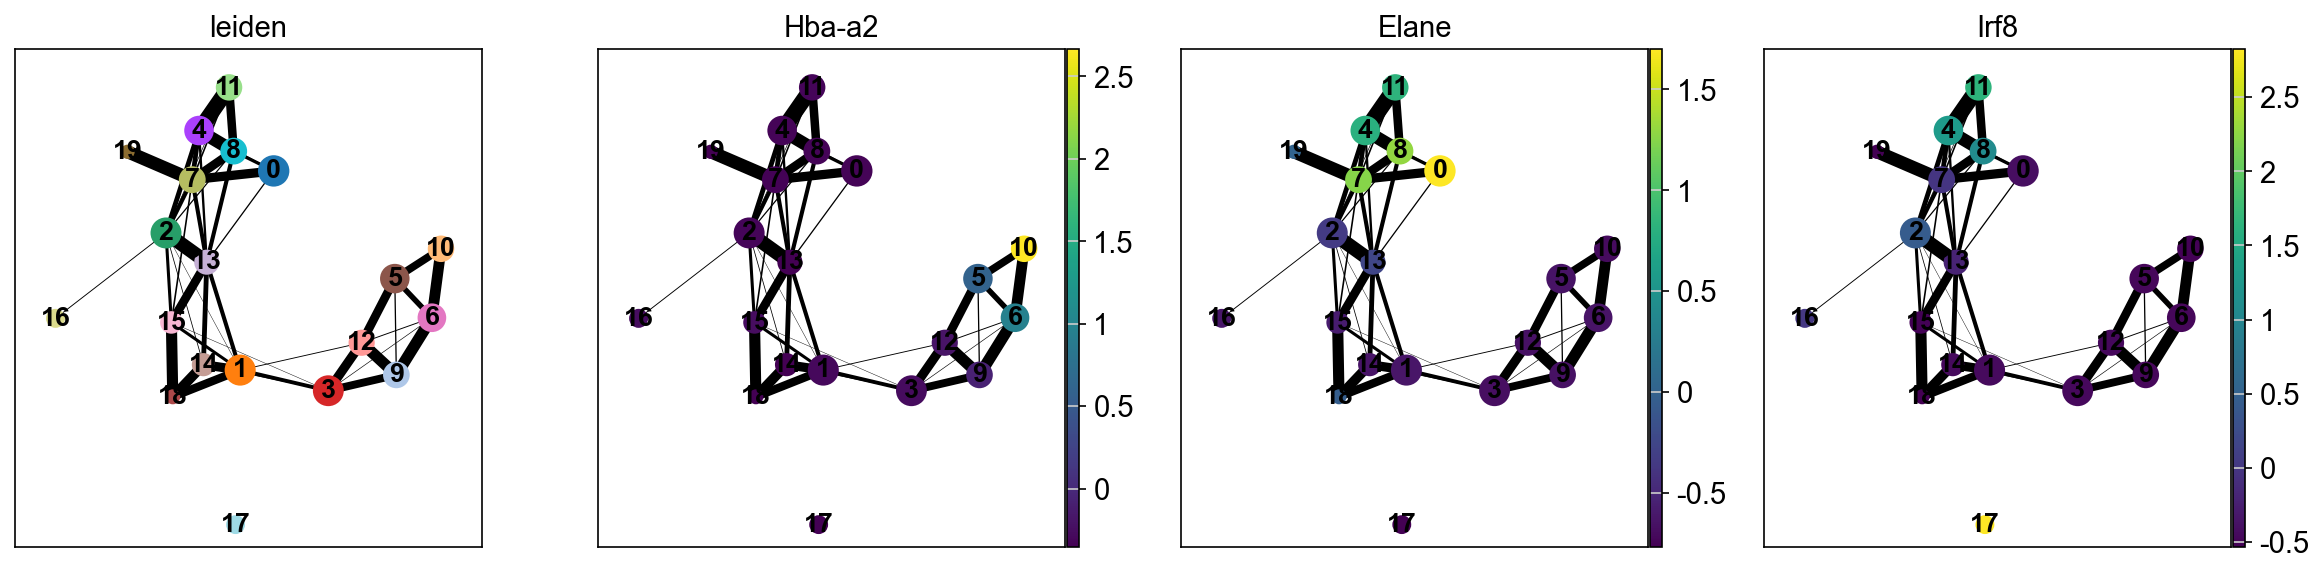

In [13]:
sc.pl.paga(adata, color=['leiden', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


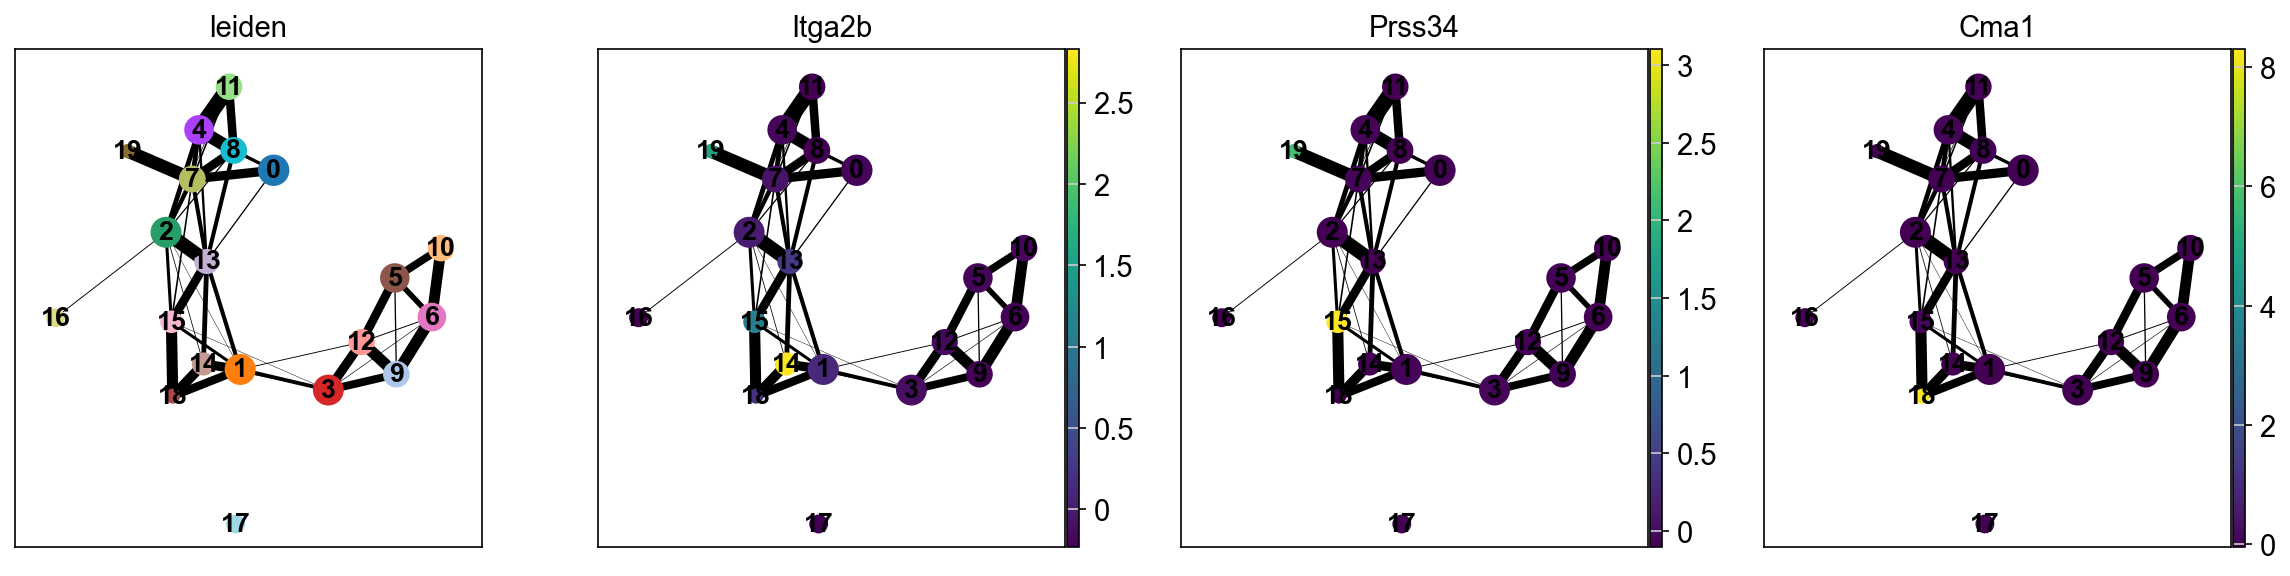

In [14]:
sc.pl.paga(adata, color=['leiden', 'Itga2b', 'Prss34', 'Cma1'])

Annotaate the clusters

In [15]:
adata.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')

In [16]:
adata.obs['leiden_anno'] = adata.obs['leiden']

In [17]:
adata.obs['leiden_anno'].cat.categories = [
    '0/Neu', 
    '1', 
    '2', 
    '3', 
    '4', 
    '5', 
    '6',
    '7', 
    '8',
    '9', 
    '10/Ery', 
    '11', 
    '12',
    '13', 
    '14/Mk',
    '15/Baso', 
    '16',
    '17/Mo',
    '18/Mast', 
    '19'
]

In [18]:
sc.tl.paga(adata, groups='leiden_anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes: >

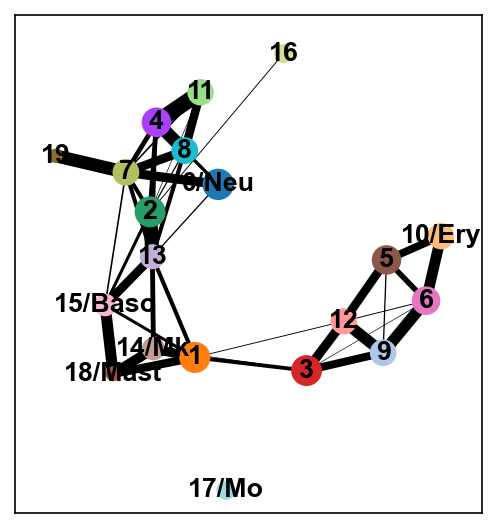

In [19]:
sc.pl.paga(adata, threshold=0.03, show=False)

In [20]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:08)


In [21]:
adata.obs['paul15_clusters'].cat.categories

Index(['1Ery', '2Ery', '3Ery', '4Ery', '5Ery', '6Ery', '7MEP', '8Mk', '9GMP',
       '10GMP', '11DC', '12Baso', '13Baso', '14Mo', '15Mo', '16Neu', '17Neu',
       '18Eos', '19Lymph'],
      dtype='object')

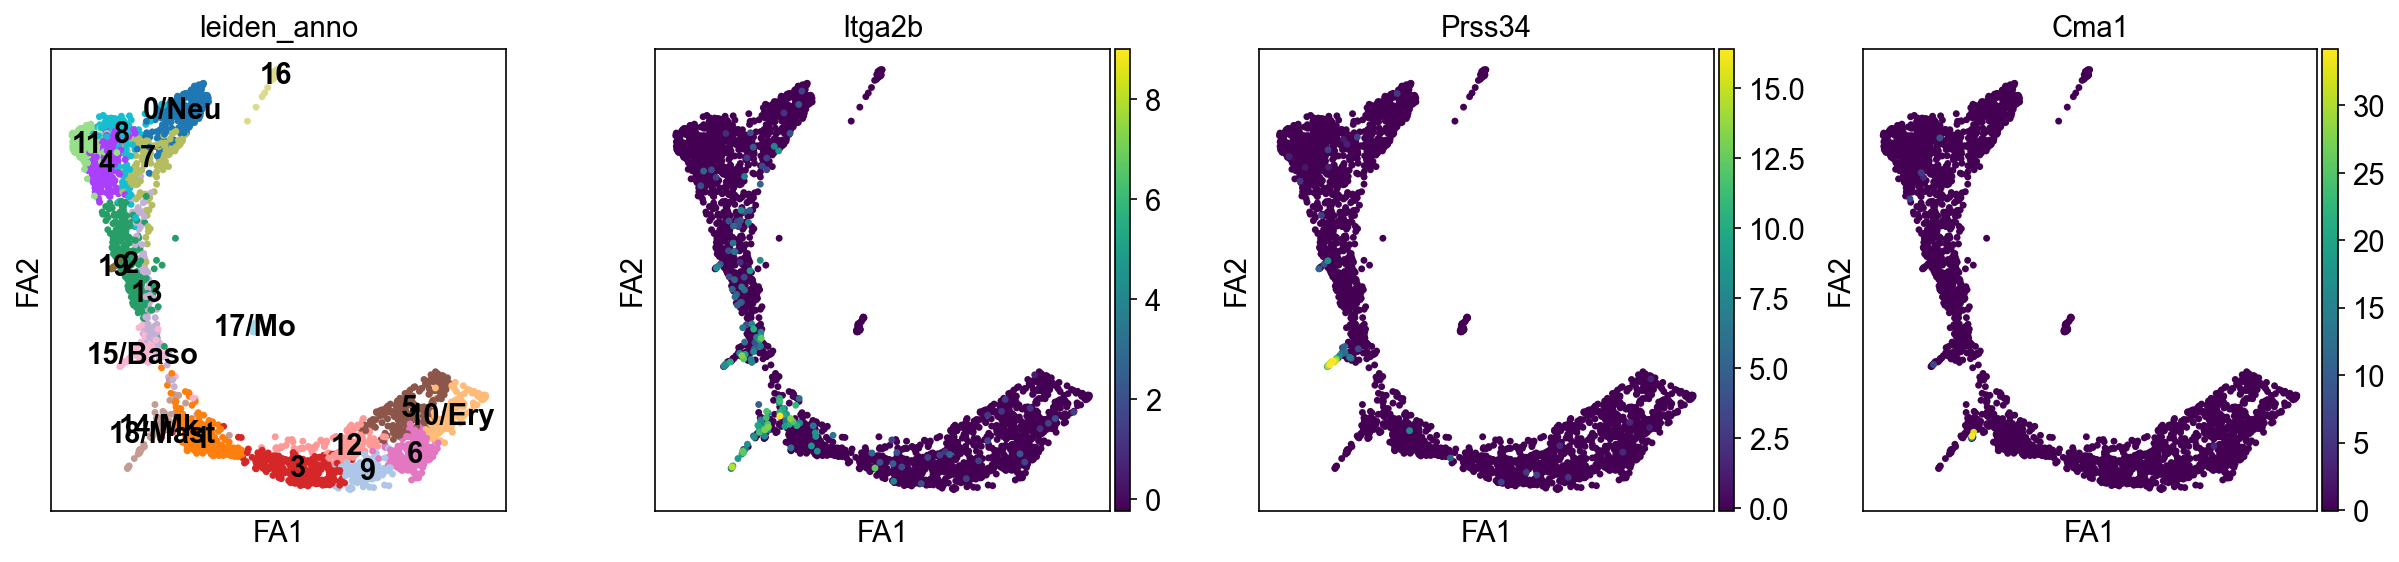

In [22]:
sc.pl.draw_graph(
    adata, 
    color=['leiden_anno', 'Itga2b', 'Prss34', 'Cma1'],
    legend_loc='on data'
)

--> added 'pos', the PAGA positions (adata.uns['paga'])


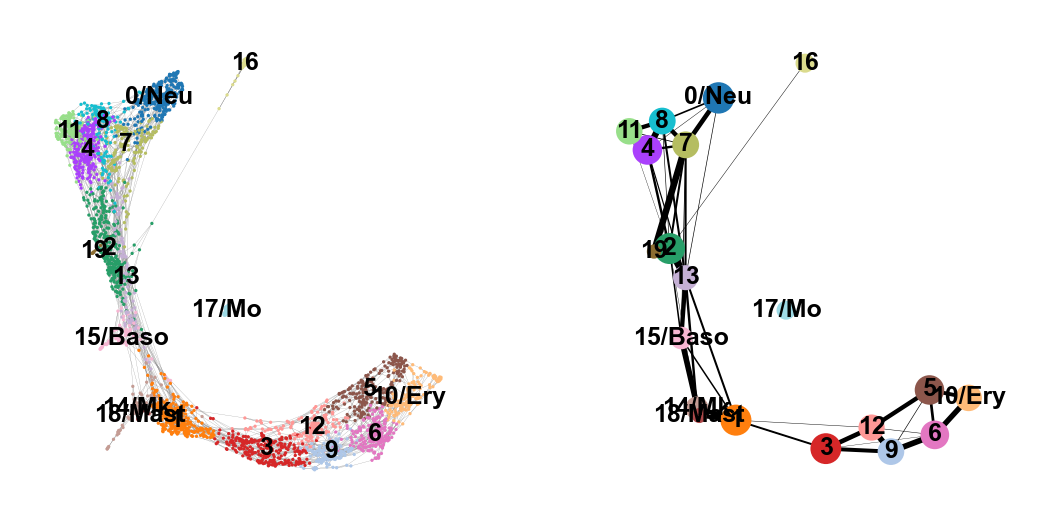

In [23]:
sc.pl.paga_compare(
    adata, 
    threshold=0.03, 
    title='',
    right_margin=0.2, 
    size=10, 
    edge_width_scale=0.5,
    legend_fontsize=12,
    fontsize=12,
    frameon=False,
    edges=True,
    save=True
)

## Pseudotime reconstruction

Choose a root cell

In [24]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_anno']  == '7')[0]

In [25]:
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989645  0.9967852  0.9944012  0.9892853
     0.98826355 0.9871257  0.98383176 0.98297554 0.97893256 0.97689945
     0.97440886 0.9727857  0.9661876 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [26]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [27]:
adata_raw = paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

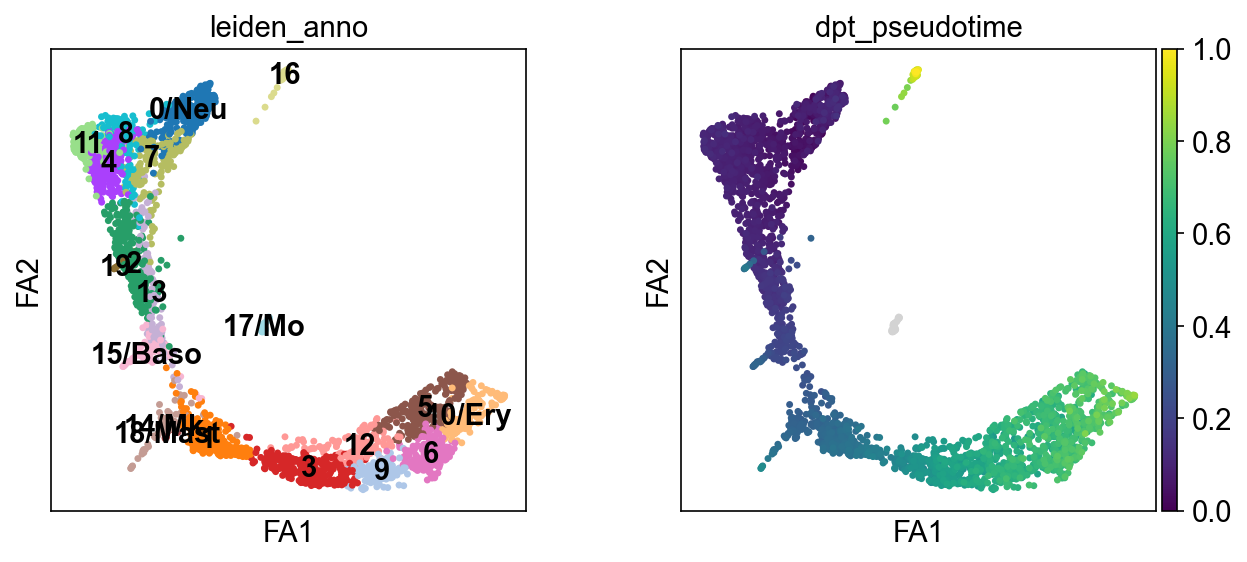

In [28]:
sc.pl.draw_graph(
    adata, 
    color=['leiden_anno', 'dpt_pseudotime'], 
    legend_loc='on data')